# Denoise Preprocessed Data
This notebook denoises Study 1 & 2 Preprocessed data and extracts ROIs from a k=50 whole brain parcellation

In [1]:
%matplotlib inline

import warnings
from copy import deepcopy
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltools.stats import (threshold, 
                           align,
                           zscore,
                           fdr, 
                           isc)
from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.mask import expand_mask
from nilearn.plotting import plot_glass_brain


warnings.filterwarnings('ignore')

base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

In [2]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)


# Study1
## Denoise

In [71]:
data_dir = '/Volumes/Engram/Data/vmpfc/Data/fMRI'

csf = Brain_Data(os.path.join(base_dir, 'Masks', 'csf.nii.gz'))

outlier_cutoff = 3
tr = 2.0

file_list = glob.glob(os.path.join(data_dir,'Study1','Preprocessed','*'))

for episode in ['ep01', 'ep02']:
    for f in tqdm(file_list):
        sub = os.path.basename(f)

        dat = Brain_Data(os.path.join(f,'functional', episode, f'{episode}_smooth_6_int16.nii.gz'))

        spikes = dat.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff)
        covariates = pd.read_csv(os.path.join(f, 'functional', episode, 'covariates.csv'))
        mc_cov = make_motion_covariates(covariates.iloc[:,:6], tr=2)

        dm = Design_Matrix(pd.concat([mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
        dm['CSF'] = zscore(pd.Series(dat.extract_roi(csf.threshold(upper=0.85, binarize=True))))
        dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends

        dat.X = dm
        stats = dat.regress()
        stats['residual'].data = np.float32(stats['residual'].data) # cast as float32 to reduce storage space
        stats['residual'].write(os.path.join(data_dir, 'Study1', 'Denoised',f'{sub}_{episode}_smooth6_denoised.nii.gz'))
        stats['residual'].write(os.path.join(data_dir, 'Study1', 'Denoised',f'{sub}_{episode}_smooth6_denoised.hdf5'))


## Write out ROI to csv

In [84]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

for episode in ['ep01', 'ep02']:
    file_list = glob.glob(os.path.join(data_dir, 'Study1', 'Denoised',f'*{episode}*denoised.hdf5'))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        print(sub, episode)
        data = Brain_Data(f)
        for i,m in enumerate(mask_x):
            roi = data.apply_mask(m)
            pd.DataFrame(roi.data).to_csv(os.path.join(data_dir, 'Study1', 'Denoised_ROI', f"{sub}_{episode}_Denoised_ROI{i}.csv" ), index=False)


08may16cb ep01
08may16ec ep01
09may16dw ep01
13may16ag ep01
13may16ap ep01
15may16sg ep01
17may16br ep01
17may16vc ep01
18may16hl ep01
19may16kh ep01
19may16sf ep01
22may16eb ep01
22may16mm ep01
08may16cb ep02
08may16ec ep02
09may16dw ep02
13may16ag ep02
13may16ap ep02
15may16sg ep02
17may16br ep02
17may16vc ep02
18may16hl ep02
19may16kh ep02
19may16sf ep02
22may16eb ep02
22may16mm ep02


# Study 2
## Denoise

In [95]:
data_dir = '/Volumes/Engram/Data/vmpfc/Data/fMRI'

csf = Brain_Data(os.path.join(base_dir, 'Masks', 'csf.nii.gz'))

outlier_cutoff = 3
tr = 2.0
episode = 'ep01'

file_list = glob.glob(os.path.join(data_dir,'Study2','Preprocessed','*'))

for f in tqdm(file_list):
    sub = os.path.basename(f)

    dat = Brain_Data(os.path.join(f, 'functional', '_fwhm_6.0', f'{sub}_task-movie_run-01_bold_trim_mcf_trans_smooth_int16.nii.gz'))

    spikes = dat.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff)
    covariates = pd.read_csv(os.path.join(f, 'functional', 'covariates.csv'))
    mc_cov = make_motion_covariates(covariates.iloc[:,:6], tr=2)

    dm = Design_Matrix(pd.concat([mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
    dm['CSF'] = zscore(pd.Series(dat.extract_roi(csf.threshold(upper=0.85, binarize=True))))
    dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends

    dat.X = dm
    stats = dat.regress()
    stats['residual'].data = np.float32(stats['residual'].data) # cast as float32 to reduce storage space
    stats['residual'].write(os.path.join(data_dir, 'Study2', 'Denoised',f'{sub}_{episode}_smooth6_denoised.nii.gz'))
    stats['residual'].write(os.path.join(data_dir, 'Study2', 'Denoised',f'{sub}_{episode}_smooth6_denoised.hdf5'))


100%|██████████| 35/35 [1:34:36<00:00, 162.18s/it]


## Write out ROI to csv

In [96]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

file_list = glob.glob(os.path.join(data_dir, 'Study2', 'Denoised',f'*{episode}*denoised.hdf5'))
for f in tqdm(file_list):
    sub = os.path.basename(f).split('_')[0]
    data = Brain_Data(f)
    for i,m in enumerate(mask_x):
        roi = data.apply_mask(m)
        pd.DataFrame(roi.data).to_csv(os.path.join(data_dir, 'Study2', 'Denoised_ROI', f"{sub}_{episode}_Denoised_ROI{i}.csv" ), index=False)


100%|██████████| 35/35 [2:59:18<00:00, 307.38s/it]  


# Temporal SNR

In [30]:
data_dir = '/Volumes/Engram/Data/vmpfc/'
episode = 'ep01'

for study in ['Study1', 'Study2']:
    file_list = glob.glob(os.path.join(data_dir,'Data', study,'Preprocessed','*'))
    for f in tqdm(file_list):
        sub = os.path.basename(f)
        if study == 'Study1':
            dat = Brain_Data(os.path.join(f, 'functional', episode, f'{episode}_smooth_6_int16.nii.gz'))
        elif study == 'Study2':
            dat = Brain_Data(os.path.join(f, 'functional', '_fwhm_6.0', f'{sub}_task-movie_run-01_bold_trim_mcf_trans_smooth_int16.nii.gz'))
    
        tsnr = dat.mean()/dat.std()
        tsnr.write(os.path.join(data_dir, 'Analyses', 'tSNR', f'{sub}_{study}_{episode}_tSNR.nii.gz'))

100%|██████████| 35/35 [38:49<00:00, 66.56s/it]


Study1 1.037054 166.51077
Study2 0.0 322.43146


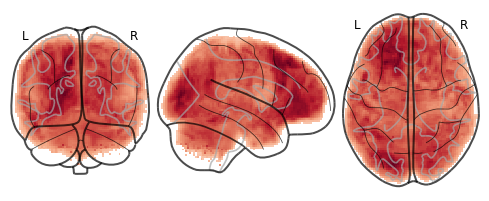

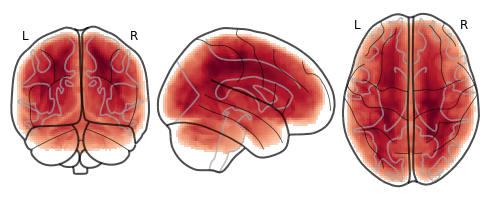

In [19]:
data_dir = '/Volumes/Engram/Data/vmpfc/'
episode = 'ep01'

for study in ['Study1', 'Study2']:
    file_list = glob.glob(os.path.join(data_dir,'Analyses', 'tSNR', f'*_{study}*.nii.gz'))
    dat = Brain_Data(file_list)
    dat.mean().write(os.path.join(data_dir, 'Analyses', 'tSNR', f'{study}_{episode}_Mean_tSNR.nii.gz'))

    cmap = 'RdBu_r'
    print(study, dat.mean().data.min(), dat.mean().data.max())
    plot_glass_brain(dat.mean().to_nifti(),display_mode='ortho', colorbar=False, cmap=cmap, plot_abs=False)
    plt.savefig(os.path.join(data_dir,'Figures','tSNR', f'{study}_mean_tSNR_Brain_Ortho_Figure.pdf'))
    plt.savefig(os.path.join(data_dir,'Figures','tSNR', f'{study}_mean_tSNR_Brain_Ortho_Figure.png'), dpi=300)
    
#     plot_glass_brain(dat.mean().to_nifti(),display_mode='lr',colorbar=False,cmap=cmap,plot_abs=False)
#     plt.savefig(os.path.join(data_dir,'Figures','tSNR', f'{study}_mean_tSNR_Brain_Lateral_Figure.pdf'))
#     plot_glass_brain(dat.mean().to_nifti(),display_mode='yz',colorbar=False,cmap=cmap,plot_abs=False)
#     plt.savefig(os.path.join(data_dir,'Figures','tSNR', f'{study}_mean_tSNR_Brain_Medial_Figure.pdf'))
